This file fetches all the API calls made from call-requests.py and takes back the result processed by NASA's API. The data is then converted into matrices and stored as the name of the chunk in a numpy file.

In [1]:
import requests as r
import getpass, pprint, time, os, cgi, json
import geopandas as gpd
import numpy as np
import shapely
from shapely import Polygon, to_geojson
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal
import shutil

api = 'https://appeears.earthdatacloud.nasa.gov/api/'  # Set the AρρEEARS API to a variable

load_dotenv()

params = {'limit': 1, 'pretty': True} # Limit API response to the most recent entry, return as pretty json
relevantFiles = [
    "MOD13A1.061__500m_16_days_EVI_",
    "MOD13A1.061__500m_16_days_NDVI_",
    "MOD15A2H.061_Lai_500m_",
    "DAYMET.004_prcp_",
    "DAYMET.004_tmax_",
    "DAYMET.004_tmin_",
]

fileOrder = ["prcp", "tmax", "tmin", "EVI", "NDVI", "Lai"]
originalRatio = [(7,6),(7,6),(7,6),(11,12),(11,12),(11,12)]

C:\Users\xubil\AppData\Local\Temp\ipykernel_25904\30379606.py:2: DeprecationWarning: 'cgi' is deprecated and slated for removal in Python 3.13
  import getpass, pprint, time, os, cgi, json


In [2]:
destDir = r"D:\Users\xubil\Wildfire Data\temp"
requestsDir = "../Requests"

In [3]:
processedFiles = np.load("processed_files.npy") # Do not re-process the same file
processedFiles

array(['r1_0-500.npy', 'r1_8238-8738.npy'], dtype='<U32')

In [151]:
np.save("processed_files", processedFiles)

In [131]:
missingFinalRequest = []

In [6]:
missing = np.load("../Requests/missing.npy")

In [5]:
for requestFile in os.listdir(requestsDir):
    if (requestFile == "cur_idx.npy" or requestFile == "missing.npy"):
        continue
    if (requestFile in processedFiles):
        continue
    accId = requestFile[1:2]
    dashIndex = requestFile.index('-')
    endIndex = requestFile.index(".npy")
    if (endIndex == -1):
        continue
    print("---------------------------------")
    print(requestFile)
    print("---------------------------------")
    startChunk = int(requestFile[3:dashIndex])
    nonIncluEndChunk = int(requestFile[dashIndex+1:endIndex])
    print(startChunk, nonIncluEndChunk)
    
    ids = np.load(requestsDir+"/"+requestFile)
    user = os.getenv("EARTHDATA_USERNAME"+str(accId))
    password = os.getenv("EARTHDATA_PASSWORD"+str(accId))
    token_response = r.post('{}login'.format(api), auth=(user, password)).json() # Insert API URL, call login service, provide credentials & return json
    token = token_response['token']                      # Save login token to a variable
    head = {'Authorization': 'Bearer {}'.format(token)}  # Create a header to store token information, needed to submit a request
    
    # # To be fixed files
    # if (ids.shape[0] != nonIncluEndChunk-startChunk):
    #     missingFinalRequest.append(requestFile)

    for chunkIdx in range(0, ids.shape[0]):
        bundle = r.get('{}bundle/{}'.format(api,ids[chunkIdx]), headers=head).json()  
        print(bundle)
        files = {}
        for f in bundle['files']: files[f['file_id']] = f['file_name']   # Fill dictionary with file_id as keys and file_name as values

        finalRelevantFiles = []

        for deleteFile in os.listdir(destDir):
            os.remove(destDir+"/"+deleteFile)

        for f in files:
            filename = files[f]
            if (".tif" in filename):
                if (any(substring in filename for substring in relevantFiles) == True):
                    filename = files[f].split('/')[1]
                    finalRelevantFiles.append(filename)
                    dl = r.get('{}bundle/{}/{}'.format(api, ids[chunkIdx], f), headers=head, stream=True, allow_redirects = 'True')   
                    filepath = os.path.join(destDir, filename)                                                       # Create output file path
                    with open(filepath, 'wb') as f:                                                                  # Write file to dest dir
                        for data in dl.iter_content(chunk_size=8192): f.write(data)
        data = []
        badFile = ""

        for filename in finalRelevantFiles:
            print(destDir + "\\" + filename)
            dem = gdal.Open(destDir + "\\" + filename)
            if (dem is None):
                print("is none")
                data.append([])
                badFile = "_bad"
                break
            else:
                demBand = dem.GetRasterBand(1) 
                demData = demBand.ReadAsArray().astype('float') 
                demFill = demBand.GetNoDataValue()
                demData[demData == demFill] = np.nan
                # Arbitray 13 x 13 shape so no out of bounds 
                if (13-demData.shape[0] < 0 or 13-demData.shape[1] < 0):
                    data.append([])
                    print("Bad process")
                    badFile = "_bad"
                    break 
                demData = np.pad(demData, [(0, 13-demData.shape[0]), (0, 13-demData.shape[1]),], mode='constant')
                data.append(demData)

        dem = "a" # stops reading the file to allow deletion 
        print(np.array(data).shape)

        np.save("D:/Users/xubil/Wildfire Data/Chunksa/"+str(chunkIdx+startChunk)+badFile, data)
    
    processedFiles = np.append(processedFiles, requestFile)
    np.save("../processed_files", processedFiles)

    

{'files': [{'sha256': '1f0c5a2df457829d3f505177f945d8c8b3e7338a4247e643c1c350b4dac24497', 'file_id': '1066c5e0-73fe-44d6-8e1c-f3586bc48dbb', 'file_name': 'DAYMET.004_2000197_to_2000197/DAYMET.004_prcp_doy2000197_aid0001.tif', 'file_size': 2618, 'file_type': 'tif', 's3_url': 's3://appeears-output/35ceb2a5-3d2e-406c-8e98-d52a3e278cad/DAYMET.004_2000197_to_2000197/DAYMET.004_prcp_doy2000197_aid0001.tif'}, {'sha256': 'd1e18526471ebd7e2ca8f4c83b14906e0c10c702cc7660759b6cf7951f648232', 'file_id': 'a8912048-d96b-454c-a5d6-0d3249efda0d', 'file_name': 'DAYMET.004_2000197_to_2000197/DAYMET.004_tmax_doy2000197_aid0001.tif', 'file_size': 2762, 'file_type': 'tif', 's3_url': 's3://appeears-output/35ceb2a5-3d2e-406c-8e98-d52a3e278cad/DAYMET.004_2000197_to_2000197/DAYMET.004_tmax_doy2000197_aid0001.tif'}, {'sha256': 'b08e60e522432390d100372331eec7c733fa8a6e1d04399cf1f19b0e3de2b7f3', 'file_id': '613589bb-2aea-4bdd-bdb2-72c7cdeb2573', 'file_name': 'DAYMET.004_2000197_to_2000197/DAYMET.004_tmin_doy200019

NameError: name 'startChunk' is not defined

### Some Testing Code

In [11]:
data

[]

In [23]:
dem = 'a'

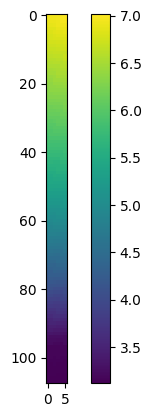

In [10]:
plt.imshow(demData)
plt.colorbar()

In [8]:
demData.shape

(108, 6)

In [144]:
print(np.array(data).shape)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (6,) + inhomogeneous part.

In [5]:
i = 1

In [16]:
ids = np.load("../Requests/r1_8238-8738.npy")

In [18]:
bundle = r.get('{}bundle/{}'.format(api,ids[0]), headers=head).json()  
files = {}
for f in bundle['files']: files[f['file_id']] = f['file_name']   # Fill dictionary with file_id as keys and file_name as values
files   


{'83cc37d8-a953-490c-ba70-17db3653e0f7': 'DAYMET.004_2007217_to_2007217/DAYMET.004_prcp_doy2007217_aid0001.tif',
 '5c4bc8ac-64b2-4395-8893-9d9eec6bf764': 'DAYMET.004_2007217_to_2007217/DAYMET.004_tmax_doy2007217_aid0001.tif',
 'ea1b28bf-aae0-4797-b429-b2e86f485a3a': 'DAYMET.004_2007217_to_2007217/DAYMET.004_tmin_doy2007217_aid0001.tif',
 'cd1e0399-59b7-4528-b38f-725260871f82': 'MOD13A1.061_2007202_to_2007217/MOD13A1.061__500m_16_days_EVI_doy2007209_aid0001.tif',
 '5cc7d63d-fe00-4610-8835-45bfa32b175d': 'MOD13A1.061_2007202_to_2007217/MOD13A1.061__500m_16_days_NDVI_doy2007209_aid0001.tif',
 '694f95e6-59ce-49ea-8295-b3c2bcc1f20d': 'MOD13A1.061_2007202_to_2007217/MOD13A1.061__500m_16_days_VI_Quality_doy2007209_aid0001.tif',
 'f3524fef-f868-436e-8867-a224fd6a967c': 'MOD15A2H.061_2007210_to_2007217/MOD15A2H.061_Lai_500m_doy2007217_aid0001.tif',
 'e37c806f-a801-476b-b297-231eb74aea23': 'MOD15A2H.061_2007210_to_2007217/MOD15A2H.061_FparLai_QC_doy2007217_aid0001.tif',
 '9d40a295-fb4f-48e1-9f68

In [19]:
finalRelevantFiles = []

for f in files:
    filename = files[f]
    if (".tif" in filename):
        if (any(substring in filename for substring in relevantFiles) == True):
            filename = files[f].split('/')[1]
            finalRelevantFiles.append(filename)
            dl = r.get('{}bundle/{}/{}'.format(api, ids[0], f), headers=head, stream=True, allow_redirects = 'True')   
            filepath = os.path.join(destDir, filename)                                                       # Create output file path
            with open(filepath, 'wb') as f:                                                                  # Write file to dest dir
                for data in dl.iter_content(chunk_size=8192): f.write(data)

In [21]:
data = []

for filename in finalRelevantFiles:
    print(destDir + "/" + filename)
    dem = gdal.Open(destDir + "/" + filename)
    if (dem is None):
        print("is none")
        data.append([])
    else:
        demBand = dem.GetRasterBand(1) 
        demData = demBand.ReadAsArray().astype('float') 
        demFill = demBand.GetNoDataValue()
        demData[demData == demFill] = np.nan
        demData = np.pad(demData, [(0, 13-demData.shape[0]), (0, 13-demData.shape[1]),], mode='constant')
        # if (demData.shape[0] < 12 or demData.shape[]): # wrong shape
        #     demData = np.pad(demData, [(0, 5), (0, 6),], mode='constant')
        print(demData.shape)
        data.append(demData)

dem = "a" # stops reading the file to allow deletion 
print(np.array(data).shape)

np.save("D:/Users/xubil/Wildfire Data/Chunks/TESTTT", data)

D:\Users\xubil\Wildfire Data\temp\DAYMET.004_prcp_doy2007217_aid0001.tif
(13, 13)
D:\Users\xubil\Wildfire Data\temp\DAYMET.004_tmax_doy2007217_aid0001.tif
(13, 13)
D:\Users\xubil\Wildfire Data\temp\DAYMET.004_tmin_doy2007217_aid0001.tif
(13, 13)
D:\Users\xubil\Wildfire Data\temp\MOD13A1.061__500m_16_days_EVI_doy2007209_aid0001.tif
(13, 13)
D:\Users\xubil\Wildfire Data\temp\MOD13A1.061__500m_16_days_NDVI_doy2007209_aid0001.tif
(13, 13)
D:\Users\xubil\Wildfire Data\temp\MOD15A2H.061_Lai_500m_doy2007217_aid0001.tif
(13, 13)
(6, 13, 13)


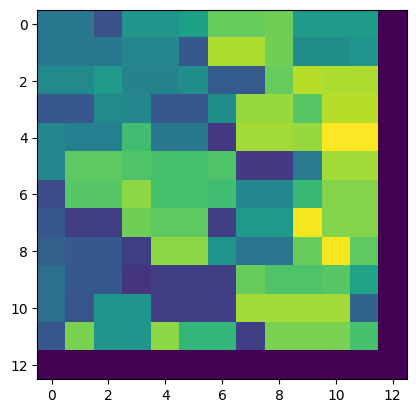

In [22]:
plt.imshow(demData)

In [105]:
test = np.load(r"D:\Users\xubil\Wildfire Data\Chunks\1.npy")

In [2]:
testing = np.load(r"D:\Users\xubil\Wildfire Data\Chunks Missing 1\Chunks\6228.npy")

In [9]:
testing[5]

array([[ 11.,  11.,  11.,   7.,   5.,   5.,   5.,   5.,   5.,   6.,   9.,
          9.,   0.],
       [ 10.,  10.,  10.,   6.,   6.,   6.,   5.,   6.,   6.,   9.,  10.,
         10.,   0.],
       [  8.,  11.,  11.,  10.,   6.,   5.,   5.,   5.,   9.,   9.,  10.,
         10.,   0.],
       [  9.,   6.,   7.,   7.,   7.,   5.,   5.,   7.,   8.,   8.,  10.,
          9.,   0.],
       [  7.,   5.,   5.,   5.,   5.,   5.,   5.,  11.,  11.,  11.,   9.,
          9.,   0.],
       [  5.,   5.,   5.,   5.,   5.,   4.,   4.,   8.,  10.,  11.,  11.,
          9.,   0.],
       [  5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   7.,   7.,   7.,
          8.,   0.],
       [  5.,   5.,   5.,   5.,   5.,   8.,   8.,   8.,   6., 254., 254.,
          5.,   0.],
       [  6.,   6.,   5.,   5.,   5.,   7.,   8.,   8.,   8.,   8.,   8.,
        254.,   0.],
       [  6.,   6.,   5.,   7.,   8.,   8.,   9.,   9.,   9.,   7.,   9.,
          9.,   0.],
       [  6.,   6.,   6.,  10.,  10.,  10.,   9., 

In [8]:
missing = np.array([25467, 25942])

In [16]:
missing.shape

(107,)

In [9]:
np.save("../Requests/missing.npy", missing)